# TIme Series Classification Task

There is a task called time series classification that predicts the class of a given time series data.

For example, human motion recognition (HAR) such as what posture or activity the user is doing based on the information of the accelerometer built in the smart watch is one of the famous applications.

In the method of inputting raw signal data, there is a famous algorithm such as Shapelet and HIVE-COTE(Ensemble model), while the method using deep learing is not so exciting compared to NLP and CV.

This note is for recoding a method of time series classification using deep learning.

## Additional Libraries
* [pyts](https://pyts.readthedocs.io/en/stable/index.html) ... Awesome time series analysis library. If you are intereseted in Shapelet Transform, you shoud use this.
* [tslearn](https://tslearn.readthedocs.io/en/stable/) ... Awesome time series analysis library. TimeSeriesScalerMeanVariance is convenient
* [enchanter](https://enchanter.readthedocs.io/en/stable/) ... The library I is creating.

In [1]:
!pip install pyts tslearn enchanter

     |████████████████████████████████| 2.5 MB 2.0 MB/s 
     |████████████████████████████████| 793 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 258 kB 3.8 MB/s 
     |████████████████████████████████| 1.4 MB 3.7 MB/s 
     |████████████████████████████████| 6.8 MB 5.4 MB/s 
     |████████████████████████████████| 515 kB 6.8 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=2b71709b9e3bd3610c4578cd83d8a391925f28d67c3811e24b222a6d8f0a52ad
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all t

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import make_cylinder_bell_funnel

Let's use the famous time series dataset. This is a similuation dataset called CBF.

In [3]:
X, y = make_cylinder_bell_funnel(n_samples=1024, random_state=0)
print(X.shape)         # [n_samples, seq_len]
print(np.unique(y))    # 3 classes

(1024, 128)
[0 1 2]


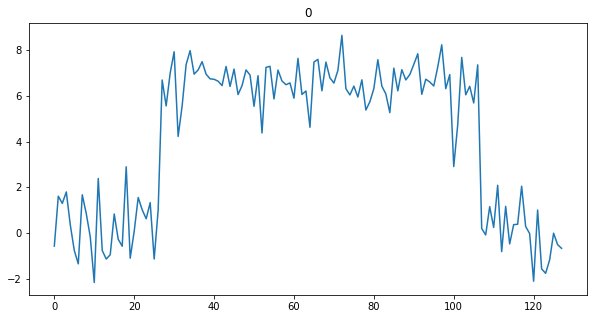

In [4]:
fig = plt.figure(figsize=(10, 5), facecolor="white")
ax = fig.add_subplot(1, 1, 1)

ax.plot(X[0])
ax.set_title(y[0])

fig.show()

## Define Model
Neural Networks used for time series classification are mainly 
1. RNN
2. CNN
3. Transfomrer(very rare)

Although there are many examples in which RNNs such as LSTM are mainly used for time series classification, many articles are mostly the result of short-circuit ideas called "series data = RNN" .

Certainly thre are data that RNN is good, but CNN is more suitable. For example, it is a "Element of action".
Imagine if the acceleration sensor build into your smartphone collects data at the time of walking.

Walking contains 
1. Raise your legs
2. Down your legs
3. ...

small movements such are combined. This cmall movement is called a behavioral element, and the sensor data should be present in the close part of the Elements of action. And, Elements of action nearby should be similar.

This is a particularly good at CNN.

Here, let's create a very simple CNN.

In [5]:
import torch
import torch.nn as nn
from enchanter.addons import layers as L

In [6]:
class CNN(nn.Module):
    def __init__(self, in_features: int, n_class: int) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            L.CausalConv1d(in_features, out_channels=32, kernel_size=3),
            nn.ReLU(),
            L.CausalConv1d(32, out_channels=32, kernel_size=3),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, n_class)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch = x.shape[0]
        out = self.conv(x)
        out = self.pool(out)
        out = out.reshape(batch, -1)
        out = self.fc(out)
        
        return out

In normal `Conv1d`, future information will alos be used to generate a new representation. On the other hand, `CausalConv` is guaranteed to use only past information to generate a new representation.

As you can see, you can only make use of the model used for image classification just by just different Convs. That is, changing the Conv in EfficientNet from 2D to 1D, it may be a powerful model in time series classification.

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


X = np.expand_dims(X, 1)     # [samples, features, seq_len]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_ds = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64))
test_ds = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [8]:
import torch.optim as optim

from enchanter.tasks import ClassificationRunner
from enchanter.callbacks import TensorBoardLogger


model = CNN(X.shape[1], len(np.unique(y)))
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

runner = ClassificationRunner(
    model, optimizer, criterion, experiment=TensorBoardLogger()
)

In [9]:
runner.add_loader("train", train_loader)
runner.add_loader("test", test_loader)

runner.train_config(epochs=50)
runner.run()

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

what's the!? Not working TensorBoard!?
```
%load_ext tensorboard.notebook
%tensorboard --logdir logs
```

In [10]:
runner.freeze()
with torch.no_grad():
    out = runner.model(torch.tensor(x_test, dtype=torch.float32))
    _, pred = out.max(1)
    
    collect = (pred == torch.tensor(y_test, dtype=torch.int64)).sum().float()
    accuracy = collect / len(y_test)
    
    print("Accuacy: {:.4f}".format(accuracy))

Accuacy: 0.9123


The above is an example of classifying time series data using CNN. This time, we used univariate data, but in the case of multivariate, we can handle it by changing the number of input channels.

As in other areas, recent time series classification is booming with self-supervised learning. You may want to read "Unsupervised Scalable Representation Learning for Multivariate Time Series"